In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

sns.set_context("poster")
%matplotlib inline

In [3]:
q_info = (
    pl.scan_csv("/Users/maxverbiest/PhD/data/str_panels/tral_and_perf_panel_meta_info_updated.tsv", separator="\t")
)
q_cor = (
    pl.scan_csv("../../results/gene_expression/20230517_gene_str_length_correlations_TPM_qt_only.csv")
)
q_clinical = pl.scan_csv(
    "../../data/clinical/oxana_tcga_clinical.csv"
).select(
    ["case_submitter_id", "gender", "MSI", "CMS"]
).rename(
    {"case_submitter_id": "patient"}
)


df_str_info = q_info.collect()
df_estr_correlations = q_cor.collect()
df_clinical = q_clinical.collect()

In [4]:
df_estr_correlations = (
    df_estr_correlations
        .join(df_str_info[["tmp_id", "ref", "period"]], on="tmp_id")
        .with_columns(is_eSTR = pl.col("pvalue_corrected") < 0.05).sort("pvalue_corrected")
)


In [5]:
q_mut = (
    pl.scan_csv("../../results/oxana_variation/20230607_somatic_mutation_calls_filt_autosome_only.csv")
        .filter(pl.col("tmp_id").is_in(df_estr_correlations["tmp_id"]))        
)

df_mutations = q_mut.collect().join(df_clinical[["patient", "MSI"]], on="patient")
print(df_mutations.shape)
df_mutations.head()

(863913, 12)


patient,tmp_id,period,ref,allele_a_healthy,allele_b_healthy,allele_a_tumor,allele_b_tumor,allele_a_diff,allele_b_diff,patient_len_diff,MSI
str,str,i64,i64,i64,i64,f64,f64,i64,i64,i64,str
"""TCGA-A6-2675""","""chr10_10006993…",1,10,10,10,10.0,10.0,0,0,0,"""MSS"""
"""TCGA-A6-2675""","""chr10_10022604…",1,10,10,10,10.0,10.0,0,0,0,"""MSS"""
"""TCGA-A6-2675""","""chr10_10027542…",1,10,10,10,10.0,10.0,0,0,0,"""MSS"""
"""TCGA-A6-2675""","""chr10_10050786…",2,4,4,4,4.0,4.0,0,0,0,"""MSS"""
"""TCGA-A6-2675""","""chr10_10074622…",3,5,5,5,5.0,5.0,0,0,0,"""MSS"""


In [7]:
min_n = 25

df_mutability = ( 
    df_mutations
        .with_columns(mutated = pl.col("patient_len_diff") != 0)
        .join(df_estr_correlations[["tmp_id", "is_eSTR"]], on="tmp_id")  # which STRs are eSTRs?
        .groupby(["MSI", "period", "ref", "is_eSTR"])
        .agg(mutated = pl.col("mutated").sum(), n = pl.col("mutated").count())  # get total count and mutated count for every combo of period + ref + is_eSTR for MSS and MSI
        .filter(pl.col("n") >= min_n)  # remove period + ref combos with fewer < min_n observations
        .with_columns(fraction_mutated = pl.col("mutated") / pl.col("n"))        
        .pivot(values="fraction_mutated", index=["period", "ref", "MSI"], columns="is_eSTR", aggregate_function=None)
        .with_columns(mutability_delta = ((pl.col("true") - pl.col("false")) * 100))  # get difference in mutatbility between eSTRs and STRs for all combos of period + ref + MSI
        .sort(["period", "ref", "MSI"])
        .drop_nulls()
)


df_mutability

period,ref,MSI,false,true,mutability_delta
i64,i64,str,f64,f64,f64
1,9,"""MSI""",0.013536,0.023392,0.985587
1,9,"""MSS""",0.001031,0.001087,0.005598
1,10,"""MSI""",0.077778,0.085802,0.802406
1,10,"""MSS""",0.003387,0.000312,-0.307414
1,11,"""MSI""",0.304158,0.35907,5.491222
1,11,"""MSS""",0.012623,0.01461,0.198675
1,12,"""MSI""",0.435995,0.548698,11.270348
1,12,"""MSS""",0.027461,0.015961,-1.150008
1,13,"""MSI""",0.44526,0.666667,22.140707


In [8]:
# df_mutability.groupby("MSI").agg(pl.col("mutability_delta").mean(), n=pl.col("period").count())
print(df_mutability["MSI"].value_counts())
df_mutability.groupby(["MSI", "period"], maintain_order=True).agg(pl.col("mutability_delta").mean(), n=pl.col("period").count())



shape: (2, 2)
┌─────┬────────┐
│ MSI ┆ counts │
│ --- ┆ ---    │
│ str ┆ u32    │
╞═════╪════════╡
│ MSS ┆ 48     │
│ MSI ┆ 28     │
└─────┴────────┘


MSI,period,mutability_delta,n
str,i64,f64,u32
"""MSI""",1,7.427263,20
"""MSS""",1,-3.913344,23
"""MSI""",2,3.569653,6
"""MSS""",2,1.01268,14
"""MSS""",3,1.297953,6
"""MSI""",3,-0.164474,1
"""MSS""",4,3.541548,2
"""MSI""",5,-0.276243,1
"""MSS""",5,1.769969,2


In [9]:
from scipy import stats

MSS = df_mutability.filter((pl.col("period") == 1) & (pl.col("MSI") == "MSS"))["mutability_delta"]
MSI = df_mutability.filter((pl.col("period") == 1) & (pl.col("MSI") == "MSI"))["mutability_delta"]

MSS = df_mutability.filter((pl.col("MSI") == "MSS"))["mutability_delta"]
MSI = df_mutability.filter((pl.col("MSI") == "MSI"))["mutability_delta"]

print(len(MSS), MSS.median(), len(MSI), MSI.median())
print(len(MSS), MSS.mean(), len(MSI), MSI.mean())
stats.kstest(MSS, MSI)

48 -0.11962143587392977 28 4.153700112038683
48 -1.1616506041395167 28 6.0543736355162086


KstestResult(statistic=0.3333333333333333, pvalue=0.02979338486489253, statistic_location=4.194990869879393, statistic_sign=1)

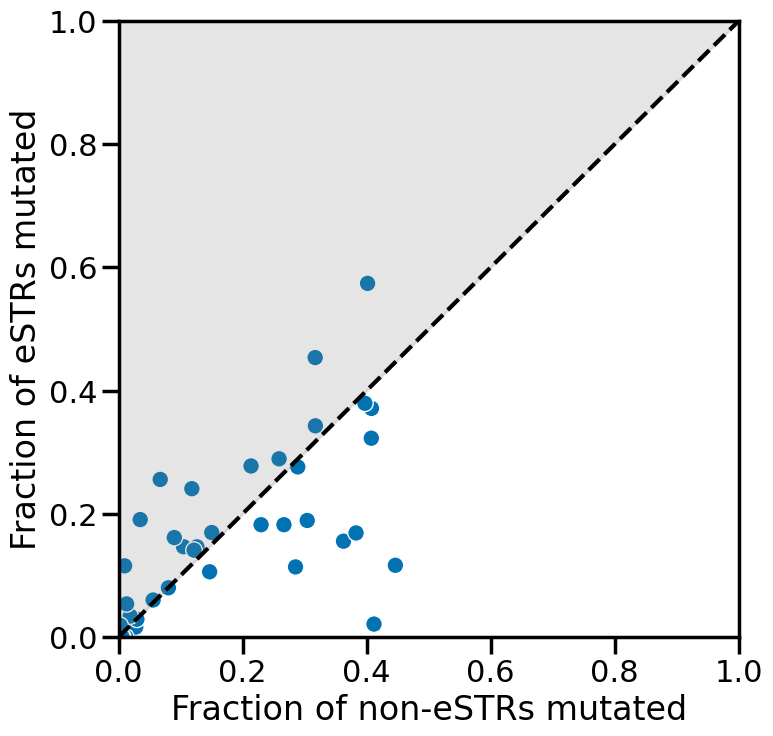

In [356]:
diag = np.arange(0, 1.1, 0.1)

fig = plt.figure(figsize = (8, 8))

ax = sns.scatterplot(
    data = df_mutability.sort("MSI", descending=True).filter(pl.col("MSI") == "MSS"),
    x = "false",
    y = "true",
    hue = "MSI",
    hue_order = ["MSS", "MSI"],
    palette="colorblind",
    legend=False
)

ax.set(
    xlim = (0, 1),
    xlabel = "Fraction of non-eSTRs mutated",
    ylim = (0, 1),
    ylabel = "Fraction of eSTRs mutated",
)

sns.lineplot(
    x=diag,
    y=diag,
    linestyle="--",
    color="black",
    ax = ax
)

ax.fill_between(
    x = diag,
    y1 = np.ones_like(diag),
    y2 = diag,
    color = "grey",
    alpha = 0.2
)

plt.show()

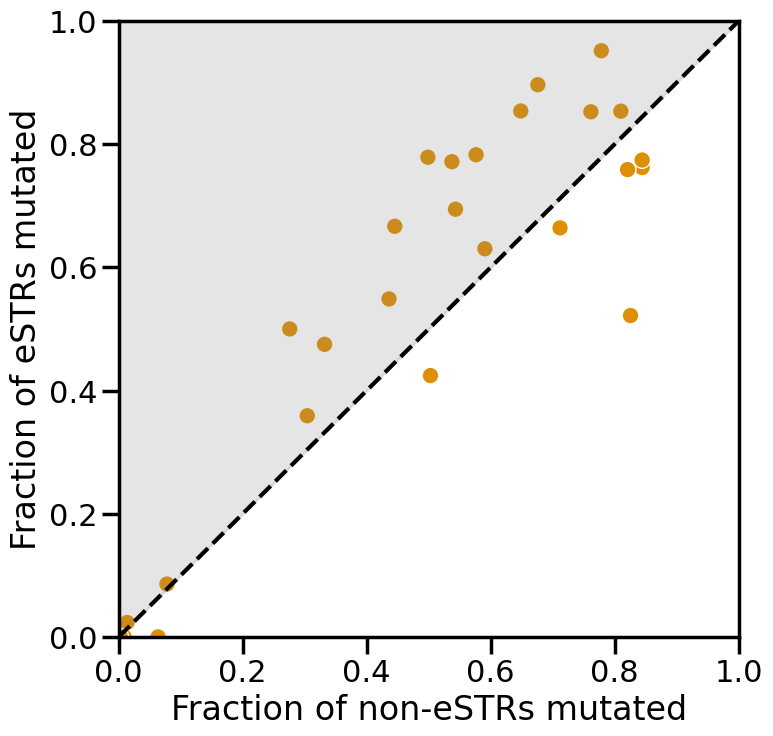

In [355]:
fig = plt.figure(figsize = (8, 8))

ax = sns.scatterplot(
    data = df_mutability.sort("MSI", descending=True).filter(pl.col("MSI") == "MSI"),
    x = "false",
    y = "true",
    hue = "MSI",
    hue_order = ["MSS", "MSI"],
    palette="colorblind",
    legend=False
)

ax.set(
    xlim = (0, 1),
    xlabel = "Fraction of non-eSTRs mutated",
    ylim = (0, 1),
    ylabel = "Fraction of eSTRs mutated",
)

sns.lineplot(
    x=diag,
    y=diag,
    linestyle="--",
    color="black",
    ax = ax
)

ax.fill_between(
    x = diag,
    y1 = np.ones_like(diag),
    y2 = diag,
    color = "grey",
    alpha = 0.2
)

plt.show()

## Permutations

In [327]:
min_n = 25

df_eSTR_labels = df_estr_correlations[["tmp_id", "is_eSTR"]].unique().groupby("tmp_id").agg(pl.col("is_eSTR").max())

rng = np.random.default_rng(seed=42)
n_permutations = 10000
seeds = [rng.integers(1e9) for _ in range(n_permutations)]
if not len(seeds) == len(set(seeds)):
    raise ValueError("Duplicate seeds generated!!!")

In [328]:
%%time
MSI = "MSS"

df_current_mutations = ( 
        df_mutations
            .filter(pl.col("MSI") == MSI)
            .with_columns(mutated = pl.col("patient_len_diff") != 0)            
)

df_permutations_mss = []
for i, seed in enumerate(seeds):
    df_current_permutation = ( 
        df_current_mutations
            .join(df_eSTR_labels.with_columns(pl.col("is_eSTR").shuffle(seed)), on="tmp_id")
#             .with_columns(pl.col("is_eSTR").shuffle(seed))
            .groupby(["MSI", "period", "ref", "is_eSTR"])
            .agg(mutated = pl.col("mutated").sum(), n = pl.col("mutated").count())  # get total count and mutated count for every combo of period + ref + is_eSTR for MSS and MSI
            .filter(pl.col("n") >= min_n)  # remove period + ref combos with fewer < min_n observations
            .with_columns(fraction_mutated = pl.col("mutated") / pl.col("n"))        
            .pivot(values="fraction_mutated", index=["period", "ref"], columns="is_eSTR", aggregate_function=None)
            .with_columns(
                mutability_delta = ((pl.col("true") - pl.col("false")) * 100), # get difference in mutatbility between eSTRs and STRs for all combos of period + ref + MSI
                sample_type = pl.lit("permuted"),
                iteration = i)
            .with_columns(eSTR_more_mut = pl.col("mutability_delta") > 0)
            .sort(["period", "ref"])
            .drop_nulls()  # Drop STR classes where only MSS or MSI had enough observations
    )
    df_permutations_mss.append(df_current_permutation[["false", "true", "sample_type", "mutability_delta", "iteration", "eSTR_more_mut"]])
#     df_permutations_mss.append(df_current_permutation)

df_permutations_mss = pl.concat(df_permutations_mss)


CPU times: user 30min 28s, sys: 4min 50s, total: 35min 19s
Wall time: 9min 5s


In [366]:
print(len(df_mutability.filter(pl.col("MSI") == "MSS")))
print(df_mutability.filter(pl.col("MSI") == "MSS").with_columns(eSTR_more_mut = pl.col("mutability_delta") > 0)["eSTR_more_mut"].sum())

mss_result = df_mutability.filter(pl.col("MSI") == MSI).with_columns(eSTR_more_mut = pl.col("mutability_delta") > 0)["eSTR_more_mut"].mean()
mss_result



48
20


0.6071428571428571

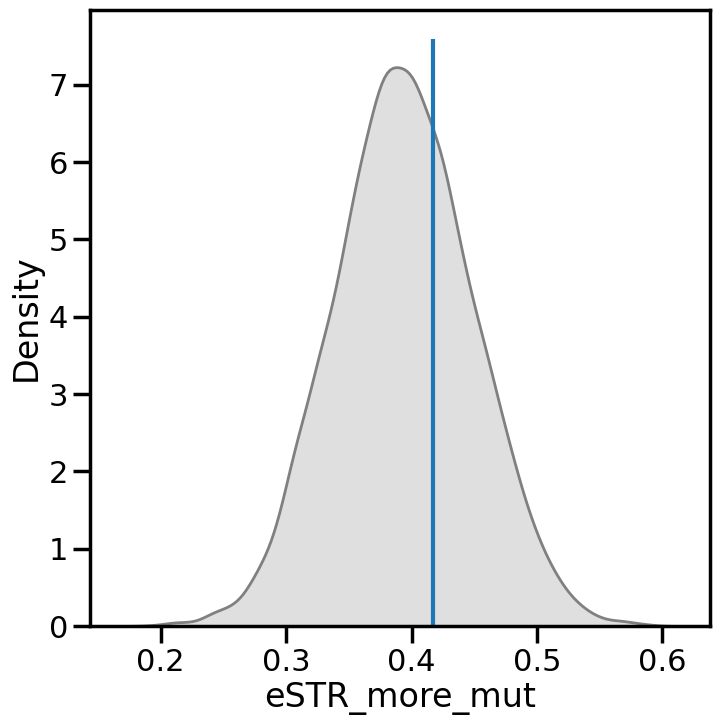

In [358]:
fig = plt.figure(figsize = (8, 8))

ax = sns.kdeplot(
    data = df_permutations_mss.groupby("iteration").agg(eSTR_more_mut = pl.col("eSTR_more_mut").mean()),
    x = "eSTR_more_mut",
    common_norm=False,
    fill=True,
#     color=sns.color_palette()[0],
    color="grey"
)

ax.vlines(
    x = mss_result,
    ymin=0,
    ymax = ax.get_ylim()[1],
#     color="black",
    color=sns.color_palette()[0],
)

plt.show()

In [331]:
%%time
MSI = "MSI"

df_current_mutations = ( 
        df_mutations
            .filter(pl.col("MSI") == MSI)
            .with_columns(mutated = pl.col("patient_len_diff") != 0)            
)

df_permutations_msi = []
for i, seed in enumerate(seeds):
    df_current_permutation = ( 
        df_current_mutations
            .join(df_eSTR_labels.with_columns(pl.col("is_eSTR").shuffle(seed)), on="tmp_id")
#             .with_columns(pl.col("is_eSTR").shuffle(seed))
            .groupby(["MSI", "period", "ref", "is_eSTR"])
            .agg(mutated = pl.col("mutated").sum(), n = pl.col("mutated").count())  # get total count and mutated count for every combo of period + ref + is_eSTR for MSS and MSI
            .filter(pl.col("n") >= min_n)  # remove period + ref combos with fewer < min_n observations
            .with_columns(fraction_mutated = pl.col("mutated") / pl.col("n"))        
            .pivot(values="fraction_mutated", index=["period", "ref"], columns="is_eSTR", aggregate_function=None)
            .with_columns(
                mutability_delta = ((pl.col("true") - pl.col("false")) * 100), # get difference in mutatbility between eSTRs and STRs for all combos of period + ref + MSI
                sample_type = pl.lit("permuted"),
                iteration = i)
            .with_columns(eSTR_more_mut = pl.col("mutability_delta") > 0)
            .sort(["period", "ref"])
            .drop_nulls()  # Drop STR classes where only MSS or MSI had enough observations
    )
    df_permutations_msi.append(df_current_permutation[["false", "true", "sample_type", "mutability_delta", "iteration", "eSTR_more_mut"]])
#     df_permutations_mss.append(df_current_permutation)

df_permutations_msi = pl.concat(df_permutations_msi)


CPU times: user 5min 10s, sys: 48 s, total: 5min 58s
Wall time: 1min 14s


In [332]:
# df_permutations_msi_plot = pl.concat([
#     df_permutations_msi.drop("iteration"),
#     df_mutability.filter(pl.col("MSI") == "MSI").with_columns(pl.lit("observed").alias("sample_type"))[["sample_type", "mutability_delta"]]
# ])

# df_permutations_msi_plot

In [365]:
print(len(df_mutability.filter(pl.col("MSI") == MSI)))
print(df_mutability.filter(pl.col("MSI") == MSI).with_columns(eSTR_more_mut = pl.col("mutability_delta") > 0)["eSTR_more_mut"].sum())

msi_result = df_mutability.filter(pl.col("MSI") == MSI).with_columns(eSTR_more_mut = pl.col("mutability_delta") > 0)["eSTR_more_mut"].mean()
msi_result



28
17


0.6071428571428571

In [334]:
df_permutations_msi.groupby("iteration").agg(eSTR_more_mut = pl.col("eSTR_more_mut").mean()).sort("eSTR_more_mut")

iteration,eSTR_more_mut
i32,f64
5364,0.146341
1821,0.148936
6771,0.16
7594,0.166667
518,0.166667
2932,0.170213
2452,0.170732
7103,0.173913
8695,0.177778


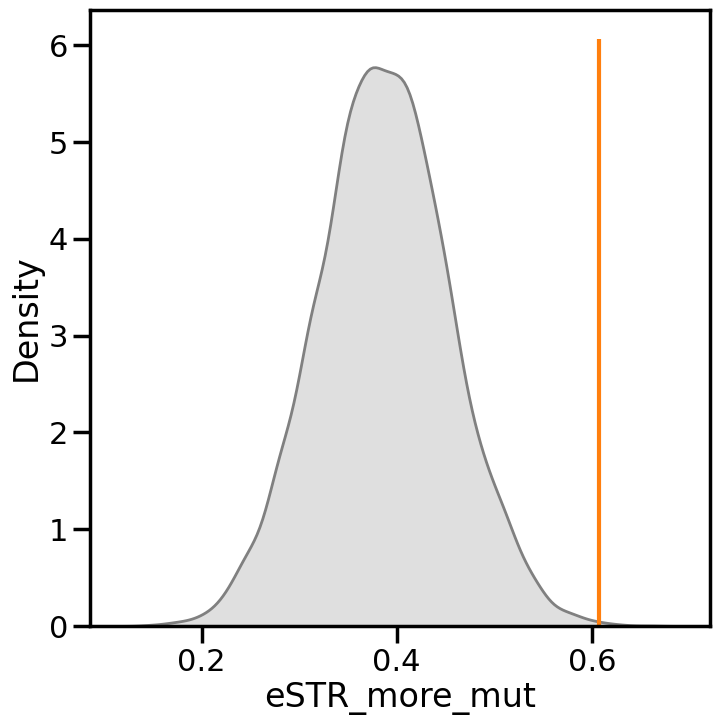

In [357]:
fig = plt.figure(figsize = (8, 8))

ax = sns.kdeplot(
    data = df_permutations_msi.groupby("iteration").agg(eSTR_more_mut = pl.col("eSTR_more_mut").mean()),
    x = "eSTR_more_mut",
    common_norm=False,
    fill=True,
#     color=sns.color_palette()[1],
    color="grey"
)

ax.vlines(
    x = msi_result,
    ymin=0,
    ymax = ax.get_ylim()[1],
#     color="black",
    color=sns.color_palette()[1],
)

plt.show()

In [336]:
def permutation_test(observed, permuted):
    b = sum(permuted > observed)
    m = len(permuted)
    
    return (b + 1) / (m + 1)

In [337]:
pval_msi = permutation_test(observed=msi_result, permuted=df_permutations_msi.groupby("iteration").agg(eSTR_more_mut = pl.col("eSTR_more_mut").mean())["eSTR_more_mut"])

pval_mss = permutation_test(observed=mss_result, permuted=df_permutations_mss.groupby("iteration").agg(eSTR_more_mut = pl.col("eSTR_more_mut").mean())["eSTR_more_mut"])

pval_mss, pval_msi

(0.3294670532946705, 0.0007999200079992001)